<a href="https://colab.research.google.com/github/ajeet966/Machinelearning/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical # np_utils is deprecated, use to_categorical directly
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive')  # Change to your specific directory


In [ ]:
import zipfile

# Path to your ZIP file
zip_file_path = '/content/drive/MyDrive/TESS Toronto emotional speech set data.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ExtractedFolder')  # Extract to a specific folder


In [ ]:
extracted_folder_path = '/content/drive/MyDrive/ExtractedFolder'
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)


In [37]:
Tess = '/content/drive/MyDrive/ExtractedFolder/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/'

In [38]:
file_emotion = []
file_path = []

In [39]:
# List all directories in the TESS folder
tess_directory_list = os.listdir(Tess)

# Iterate over each directory
for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)  # Get the full path of the directory
    if os.path.isdir(dir_path):  # Check if it's a directory
        # List all files in the directory
        directories = os.listdir(dir_path)
        for file in directories:
            file_path_full = os.path.join(dir_path, file)  # Full path to the file
            # Extract the emotion from the filename
            parts = file.split('.')[0].split('_')
            print(f"Filename: {file}, Parts: {parts}")  # Debugging line

            if len(parts) > 2:  # Ensure there are enough parts in the filename
                part = parts[2]
                if part == 'ps':
                    emotion = 'surprise'
                else:
                    emotion = part
                file_emotion.append(emotion)
                file_path.append(file_path_full)
            else:
                print(f"Skipping file with unexpected format: {file}")

# Create dataframes for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine the dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
print(Tess_df.head(20))

Filename: OAF_back_angry.wav, Parts: ['OAF', 'back', 'angry']
Filename: OAF_bar_angry.wav, Parts: ['OAF', 'bar', 'angry']
Filename: OAF_base_angry.wav, Parts: ['OAF', 'base', 'angry']
Filename: OAF_beg_angry.wav, Parts: ['OAF', 'beg', 'angry']
Filename: OAF_bean_angry.wav, Parts: ['OAF', 'bean', 'angry']
Filename: OAF_bath_angry.wav, Parts: ['OAF', 'bath', 'angry']
Filename: OAF_book_angry.wav, Parts: ['OAF', 'book', 'angry']
Filename: OAF_bite_angry.wav, Parts: ['OAF', 'bite', 'angry']
Filename: OAF_boat_angry.wav, Parts: ['OAF', 'boat', 'angry']
Filename: OAF_bought_angry.wav, Parts: ['OAF', 'bought', 'angry']
Filename: OAF_bone_angry.wav, Parts: ['OAF', 'bone', 'angry']
Filename: OAF_burn_angry.wav, Parts: ['OAF', 'burn', 'angry']
Filename: OAF_calm_angry.wav, Parts: ['OAF', 'calm', 'angry']
Filename: OAF_came_angry.wav, Parts: ['OAF', 'came', 'angry']
Filename: OAF_cab_angry.wav, Parts: ['OAF', 'cab', 'angry']
Filename: OAF_cause_angry.wav, Parts: ['OAF', 'cause', 'angry']
Filename

In [40]:
# Assuming Ravdess_df, Crema_df, Tess_df, and Savee_df are already defined
data_path = pd.concat([ Tess_df], axis=0)

# Save the combined DataFrame to a CSV file
data_path.to_csv("data_path.csv", index=False)

# Display the first few rows of the combined DataFrame
print(data_path.head())

  Emotions                                               Path
0    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
1    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
2    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
3    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
4    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...


In [41]:
# Check the structure of the combined DataFrame
print(data_path.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  2800 non-null   object
 1   Path      2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB
None


In [42]:
data_path.Emotions.value_counts()

,count
Emotions,
angry,400
disgust,400
fear,400
happy,400
neutral,400
surprise,400
sad,400


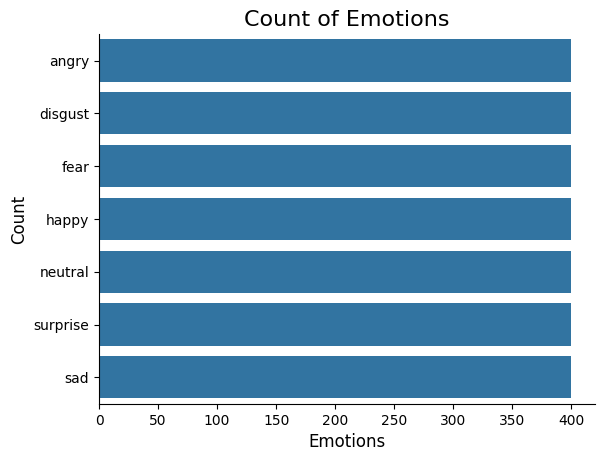

In [25]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

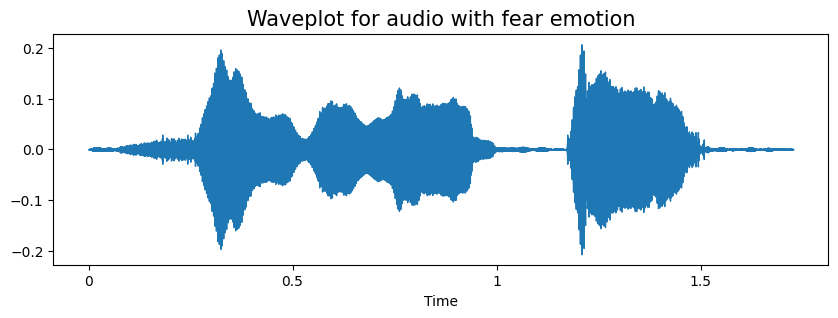

<ipython-input-26-c12dd26c172a>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


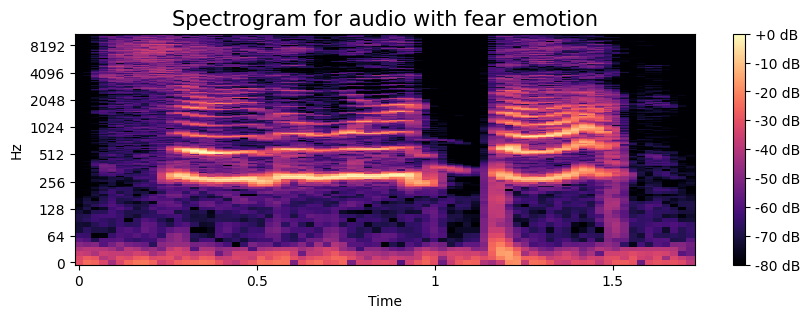

In [26]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

emotion = 'fear'  # Example emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load audio file
data, sampling_rate = librosa.load(path)

# Create waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

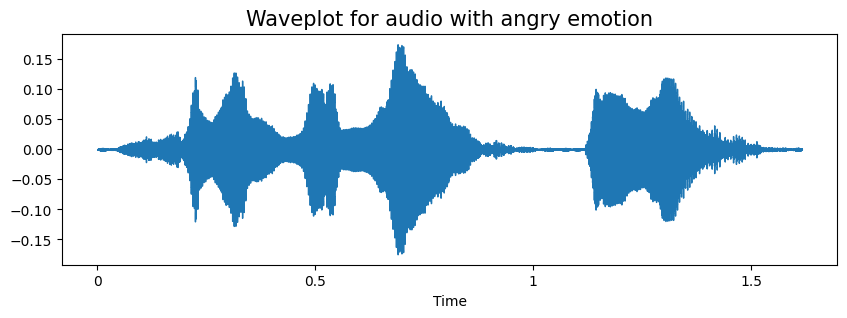

<ipython-input-26-c12dd26c172a>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


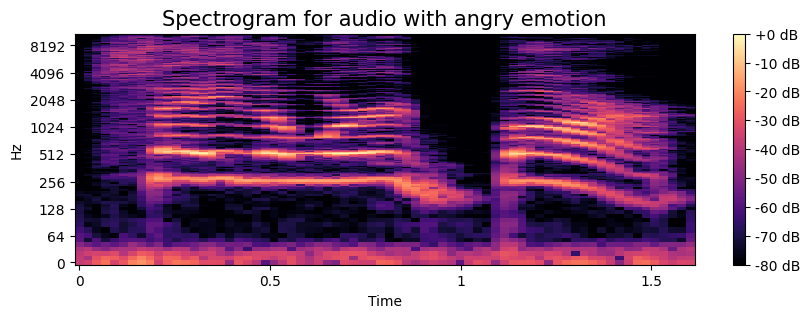

In [27]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

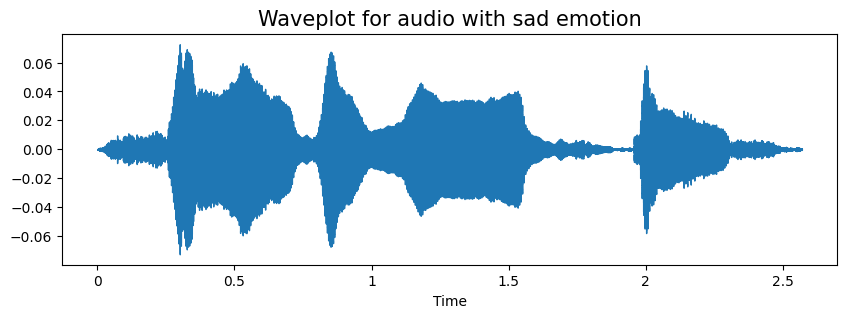

<ipython-input-26-c12dd26c172a>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


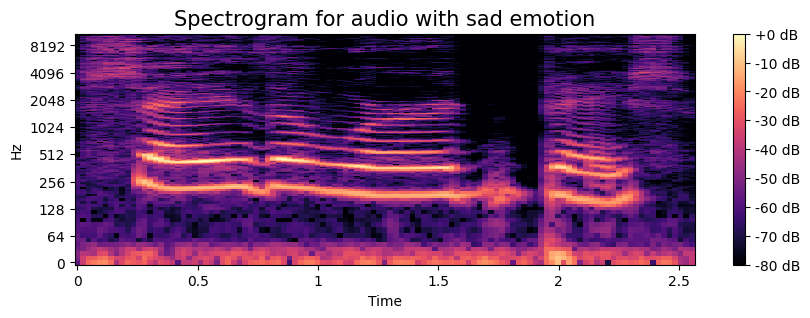

In [28]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

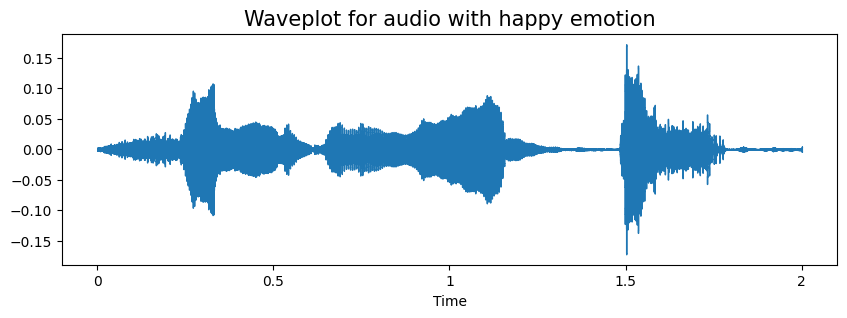

<ipython-input-26-c12dd26c172a>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


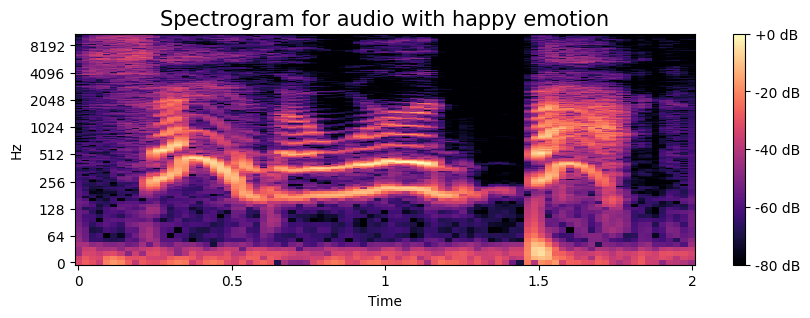

In [29]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [30]:
# Define the augmentation functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    # Convert pitch_factor to half-steps
    n_steps = pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)


# Load the example audio file
path = np.array(data_path.Path)[1]  # Select an example file from data_path
data, sample_rate = librosa.load(path)

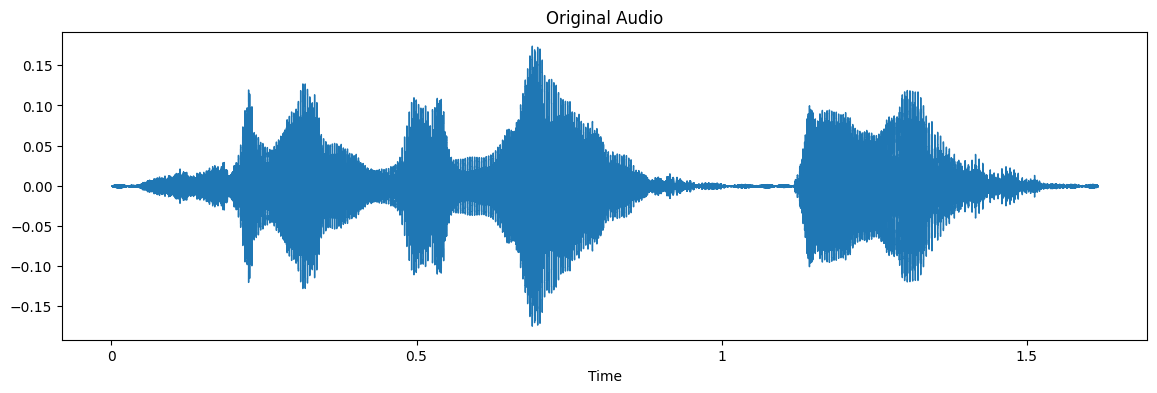

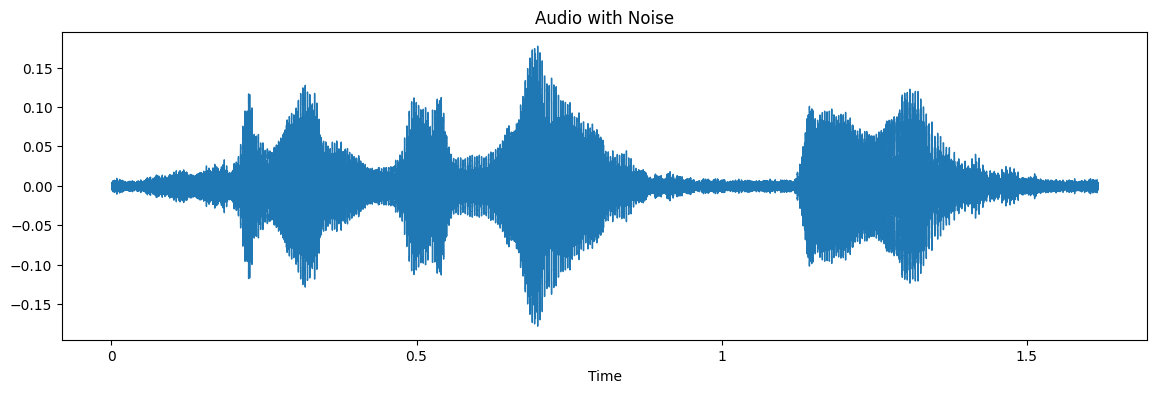

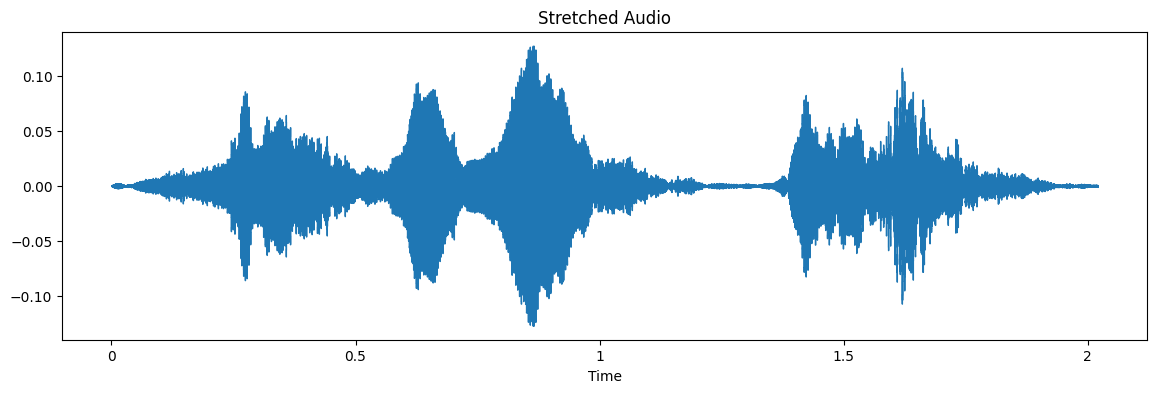

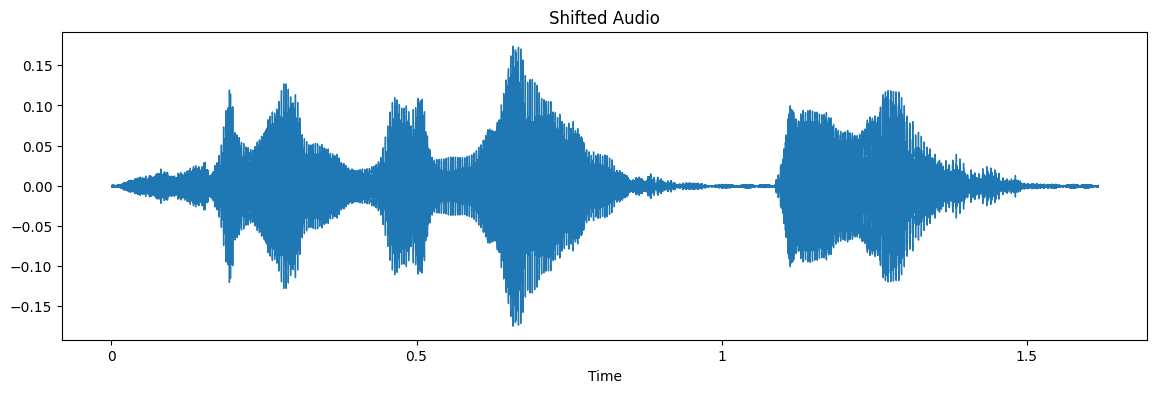

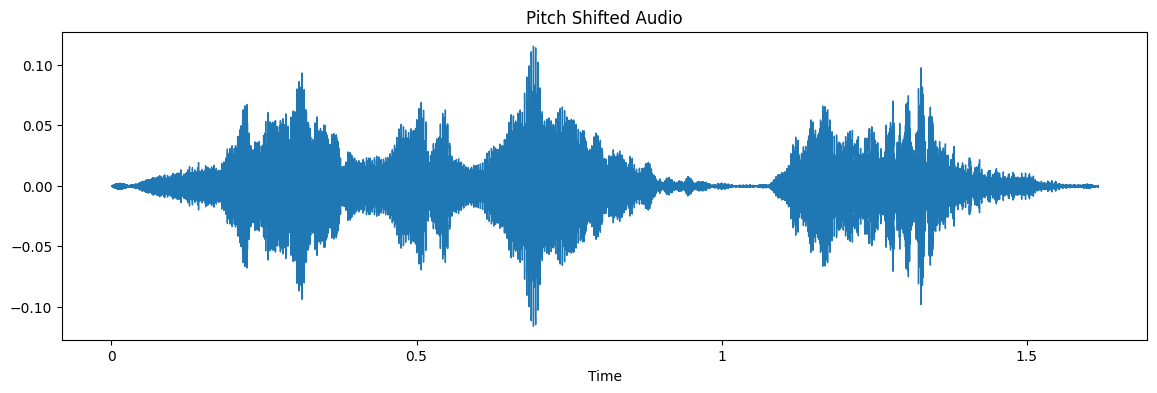

In [31]:
# Plot and play the original audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Original Audio')
plt.show()
Audio(path)

# Apply noise augmentation and visualize
data_noisy = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_noisy, sr=sample_rate)
plt.title('Audio with Noise')
plt.show()

# Apply time stretch augmentation and visualize
data_stretched = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_stretched, sr=sample_rate)
plt.title('Stretched Audio')
plt.show()

# Apply shifting augmentation and visualize
data_shifted = shift(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_shifted, sr=sample_rate)
plt.title('Shifted Audio')
plt.show()

# Apply pitch shift augmentation and visualize
data_pitched = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_pitched, sr=sample_rate)
plt.title('Pitch Shifted Audio')
plt.show()

# Play the augmented audio (example for noisy audio)
Audio(data_noisy, rate=sample_rate)

In [32]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [33]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [34]:
len(X), len(Y), data_path.Path.shape

(8400, 8400, (2800,))

In [35]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.538993,0.596808,0.396304,0.364695,0.441099,0.413557,0.373404,0.568095,0.573010,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250610e-06,angry
1,0.261195,0.720038,0.764285,0.588352,0.565939,0.650720,0.615196,0.497523,0.664594,0.683325,...,0.006336,0.006645,0.006557,0.006433,0.006788,0.006467,0.006742,0.006169,6.696360e-03,angry
2,0.073797,0.544297,0.592770,0.374067,0.335806,0.388974,0.397721,0.296942,0.535106,0.623338,...,0.000029,0.000026,0.000024,0.000037,0.000041,0.000037,0.000024,0.000007,3.820605e-07,angry
3,0.058006,0.635519,0.406851,0.370775,0.404711,0.507197,0.455434,0.395454,0.421722,0.353537,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260876e-07,angry
4,0.191817,0.772535,0.716509,0.552505,0.528670,0.571062,0.581318,0.458011,0.475661,0.495289,...,0.000633,0.000602,0.000565,0.000508,0.000584,0.000602,0.000577,0.000588,5.748492e-04,angry


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))
